<a href="https://colab.research.google.com/github/bamacgabhann/GY4006/blob/main/gy4006/notebooks/GY4006_8_Introduction_To_Raster_Data.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

<img src="https://raw.githubusercontent.com/bamacgabhann/GY4006/main/gy4006/assets/images/GY4006_logo_1.png" align=center alt="UL Geography logo"/>

# Raster Data

In the previous Notebooks, we introduced some different types of data which computers can process, how geospatial coordinates of different kinds and in different coordinate reference systems can be stored as data, how additional data can be associated with those coordinates as attributes, and how we can do some processing of that coordinate and attribute data.

However, this kind of data, known as *vector* data, is not always a good format in which to store or process geospatial data. 

## 1. Images and Pixels

For example, what if we wanted to show a satellite photograph? Let's use an example of a satellite image I have of Killarney National Park in County Kerry from April 2021. 

(We'll use the python library ```rasterio``` to work with images here, and we'll also import a couple of other libraries we might want to use)

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install rasterio

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show

In [3]:
photo = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color.tiff'
)
show(photo)

RasterioIOError: HTTP response code: 404

It's a nice cloud-free image (which doesn't always happen in Ireland, of course - one reason for using an image from 2021, because I know this one is cloud-free!). To see why vector data isn't a great format for this, let's zoom in on one of the islands in the lake: 

In [4]:
island = rio.open(
    'https://github.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/killarney_zoom.tif'
)
show(island)

RasterioIOError: HTTP response code: 404

We can clearly see here that the photo of the island is made up of a bunch of squares, each with a different colour. These squares are individual *pixels*. Each pixel has a colour.

Actually, each pixel has *three* colours. Photographs on a screen are a combination of red, green, and blue.

NameError: name 'island' is not defined

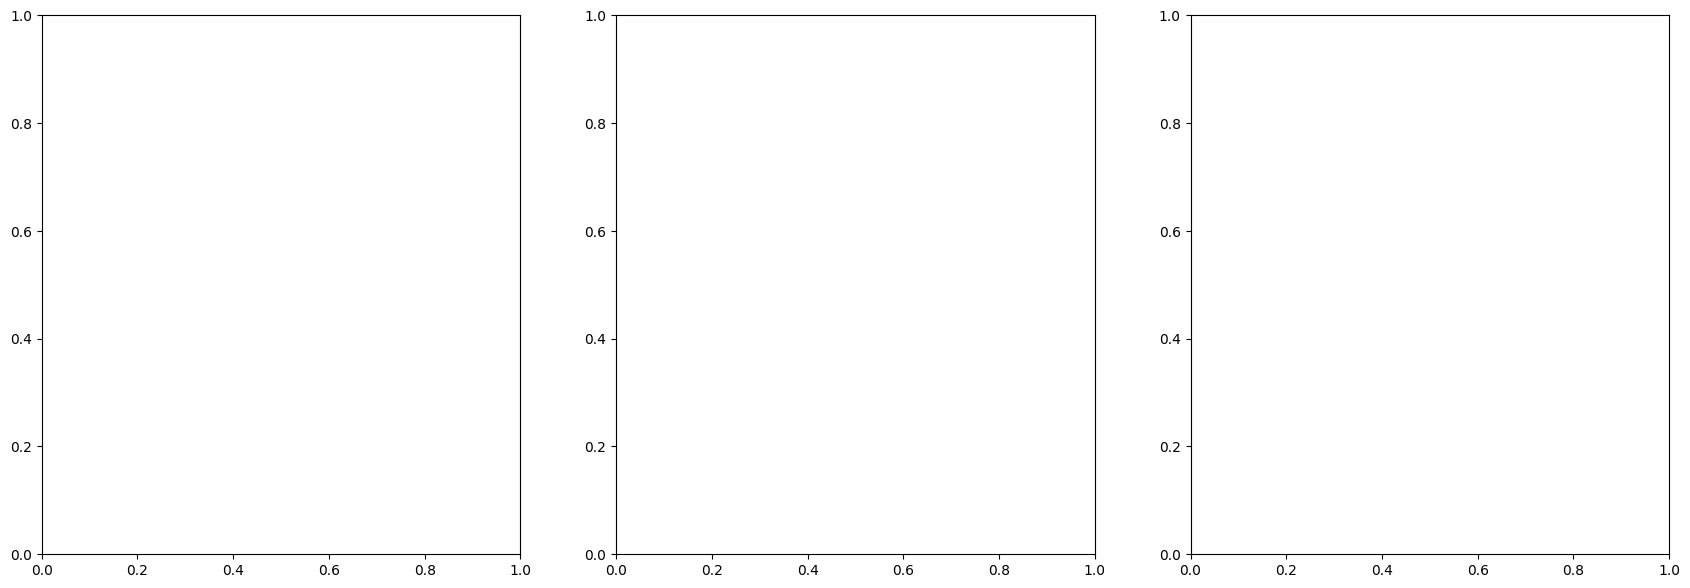

In [5]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((island, 1), ax=axr, cmap='Reds', title='red band')
show((island, 2), ax=axg, cmap='Greens', title='green band')
show((island, 3), ax=axb, cmap='Blues', title='blue band')
plt.show()

Each of these "bands" simply has a number for each pixel, specifying how much of the colour to display. Together, the numbers form an array - which in rasterio, uses numpy, just like GeoPandas. We can actually look at the numbers:

In [6]:
island.read()

NameError: name 'island' is not defined

That's still a lot of numbers, let's zoom in even further to 9x9 pixels so we can make more sense of the numbers:

In [7]:
island_zoom = rio.open(
    'https://github.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/island_zoom.tif'
)
show(island_zoom)

RasterioIOError: HTTP response code: 404

NameError: name 'island_zoom' is not defined

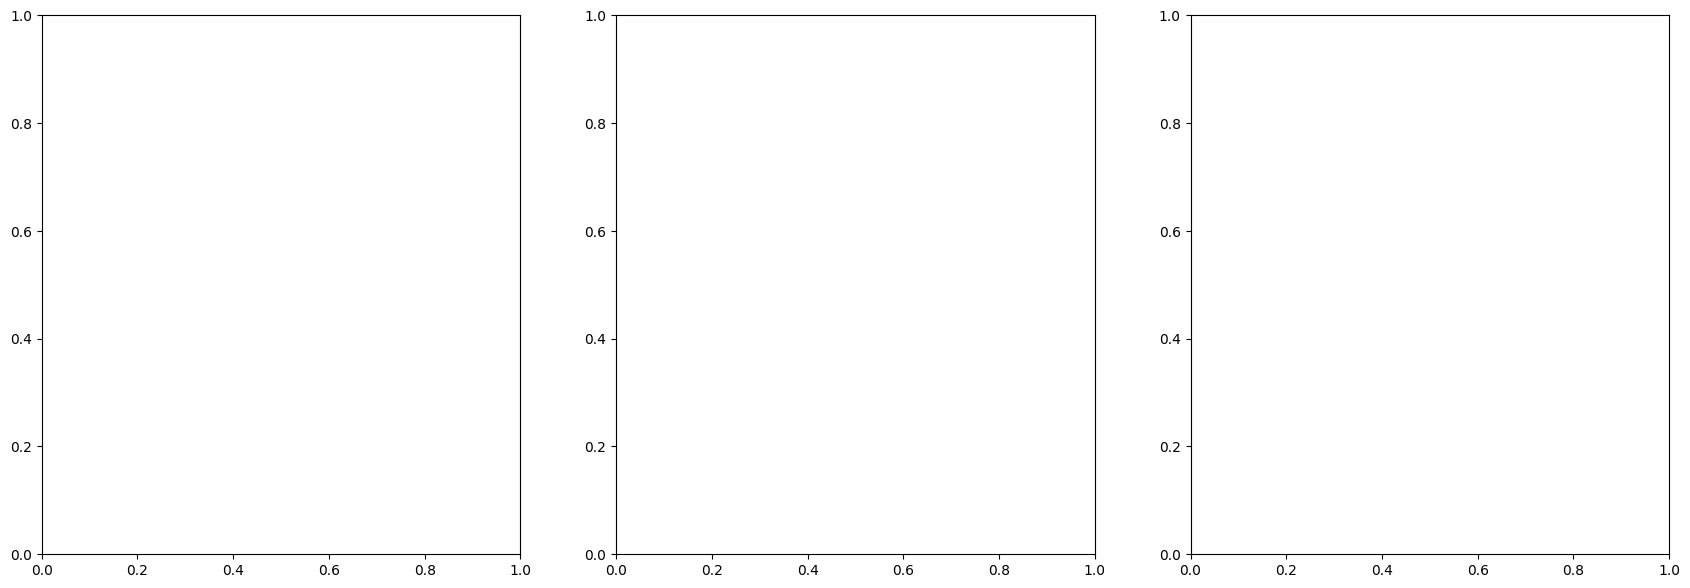

In [8]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((island_zoom, 1), ax=axr, cmap='Reds', title='red band')
show((island_zoom, 2), ax=axg, cmap='Greens', title='green band')
show((island_zoom, 3), ax=axb, cmap='Blues', title='blue band')
plt.show()

In [9]:
island_zoom.read()

NameError: name 'island_zoom' is not defined

So here, what we have is an array of arrays. The main array - the image as a whole - contains 3 arrays (for red, green, and blue), each of which contains 3 rows and 3 columns (because our image has 3x3 pixels) of numbers. 

You can see the numbers are ```float32``` decimals - for these, a value of 1.0 means 100% of that colour, and a value of 0 means 0% of that colour. 

## 2. Why Not Vector?

What you *don't* see here are coordinates - and hopefully it will be easy enough to understand why. It would be completely *possible* to store this data in vector form, with coordinates; in fact, this is what that would look like:

In [10]:
island_zoom_vector = gpd.read_file('https://github.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/island_zoom_vector.gpkg')
island_zoom_vector

HTTPError: HTTP Error 404: Not Found

(Remember the index goes up to 8 rather than 9 because it starts at 0, not 1).

Saving the data in this format makes it easier to label the values on individual pixels (and hopefully that will help you to understand the concept of pixels and colour values):

NameError: name 'island_zoom' is not defined

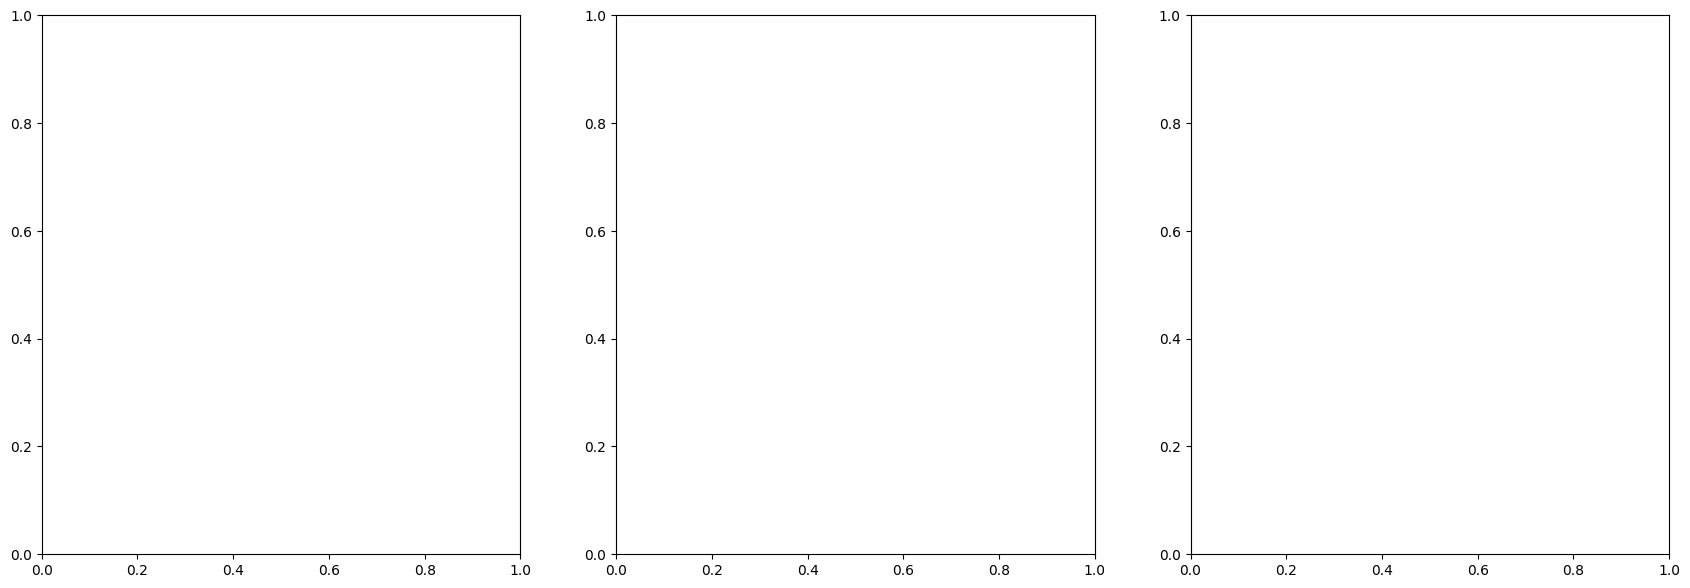

In [11]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((island_zoom, 1), ax=axr, cmap='Reds', title='red band')
show((island_zoom, 2), ax=axg, cmap='Greens', title='green band')
show((island_zoom, 3), ax=axb, cmap='Blues', title='blue band')
island_zoom_vector.apply(lambda x: axr.annotate(text="{:.4f}".format(x['Red']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
island_zoom_vector.apply(lambda x: axg.annotate(text="{:.4f}".format(x['green']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
island_zoom_vector.apply(lambda x: axb.annotate(text="{:.4f}".format(x['blue']), xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.show()

However, while that works just fine for 9 pixels, can you imagine how much data it would take to store the pixel coordinate polygons for every single pixel? 

The ```island_zoom.tif``` raster file has a size of 532 bytes, while this vector format ```island_zoom.gpkg``` is 106,496 bytes. That's 200 times larger - and that's just nine pixels. That's ridiculous.

The original image above, which we called ```photo```, has 1549 by 1148 pixels, a total of 1,778,252 pixels. Storing almost 2 million sets of polygon vector coordinate features is absolutely going to inflate the file size like a balloon. It would take up a huge amount of unnecessary file storage, plus any processing would take an enormous amount of wasted compute power. And that's just that one image, which isn't a particularly big one.

Instead, this data is stored as *raster* data. Rather than storing a polygon geometry for each pixel, it basically stores the coordinates of the corners, and any transformations which need to be applied to the data. The simplest case essentially just assumes the pixels are of equal size, and simply fill the area between the coordinates.

We can look at the *metadata* - the key information about the arrays of colour values - of our ```photo``` image:

In [12]:
photo.meta

NameError: name 'photo' is not defined

```driver``` is the type of file - in this case, ```GTiff``` meaning *GeoTiff*. *Tiff* is a common high-resolution image format, standing for *Tagged Image File Format*, and *GeoTiff* is a variant of this format which specifies the geographic coordinates. 

```dtype``` is the data type in which the colour values are stored - in this case, each colour value is a 32-bit float number between 0 and 1, as discussed above.

```nodata``` is the value associated with empty pixels - which we don't have any of here. We'll come back to this, because it is important.

```width``` and ```height``` are the size of the image in pixels. 

```count``` is how many bands the image has - in this case, 3, one each for red, green, and blue. We'll be coming back to this, as well.

```crs``` is of course the coordinate reference system, in this case EPSG:32629 - UTM Zone 29N. UTM is a coordinate system we haven't discussed yet, which is extremely useful because it uses metres rather than degrees, minutes, and seconds. Zone 29N is the area which includes Ireland.

```transform``` is the key here. This is the data which explains how the pixels are related to the coordinates. It's not important to understand the details of this - I don't! - as long as you understand that this controls how the pixels are fit to the coordinates specified. Here, it's looks fairly simply, but quite complex transforms can be applied where necessary.

Using a transform to define how the pixels relate to the coordinates massively reduces the file size, meaning we don't need to store the coordinates of each pixel - only the coordinates of the image bounds.

## 3. Spatial Resolution

Each pixel in the image covers a length and width - and has a single value. This is the *spatial resolution* of the image - the distance over the ground covered by a single pixel. This essentially depends on how good the camera on the satellite is - or whatever sensor, platform, or data source you're using. The higher the spatial resolution, the better your data will be - but of course higher spatial resolution means more pixels, which means larger file sizes.

Our original image, ```photo```, has a spatial resolution of 10m per pixel. Each pixel covers an area of 10m x 10m: 1549 x 1148 pixels, totalling 1,778,252 pixels, taking up 10,491,881 bytes of storage/memory:

In [13]:
photo = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color.tiff'
)
show(photo)

RasterioIOError: HTTP response code: 404

If we want a smaller file size, we could use a lower spatial resolution. Here's the same image at 30m per pixel - 516 x 382 pixels, total 197,112 pixels, taking up 2,104,164 bytes of memory/storage. The original resolution was 1549 x 1148: 1549/3 = 516.333, and 382.667, rounded to whole numbers because you can't have partial pixels, and that gives you the new 516 x 382 resolution.

In [14]:
photo30m = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color_30m.tiff'
)
fig, (ax, axlow) = plt.subplots(1,2, figsize=(15,11))
show(photo, ax=ax, title='10m resolution')
show(photo30m, ax=axlow, title='30m resolution')
plt.show()

RasterioIOError: HTTP response code: 404

We can't see a huge difference here because the images are shown at a small size, but if we zoom in:

In [15]:
photo30m = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color_30m.tiff'
)
fig, (ax, axlow) = plt.subplots(1,2, figsize=(15,11))
ax.set_xlim(464000, 466000)
ax.set_ylim(5766000, 5767500)
axlow.set_xlim(464000, 466000)
axlow.set_ylim(5766000, 5767500)
show(photo, ax=ax, title='10m resolution')
show(photo30m, ax=axlow, title='30m resolution')
plt.show()

RasterioIOError: HTTP response code: 404

Here's the same image at an even lower resolution of 60m per pixel - 258 x 191 pixels, total 49,278 pixels, taking up 526,864 bytes of memory/storage. That's about a quarter of the size of the 30m resolution image, because of course the resolution is in both length and width - half as many pixels lengthwise, half as many widthwise. At 30m resolution, 2 x 2 pixels covered 60m x 60m, and that's just one pixel here. Four pixels to one means a quarter of the number of pixels overall.

In [16]:
photo60m = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color_60m.tiff'
)
fig, (ax, axlow) = plt.subplots(1,2, figsize=(15,11))
show(photo, ax=ax, title='10m resolution')
show(photo60m, ax=axlow, title='60m resolution')
plt.show()

RasterioIOError: HTTP response code: 404

Even at full size, we can see the degradation in quality here.

Let's go even lower - 100m per pixel, 154 x 114 = 17,556 pixels total, in 187,924 bytes. Compared to our original 10m resolution image, this has a single pixel taking up the length of 10 pixels in the original - and a width of 10 pixels; meaning that 10 x 10 = one hundred pixels in the original is now just one single pixel here.

In [17]:
photo100m = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color_100m.tiff'
)
fig, (ax, axlow) = plt.subplots(1,2, figsize=(15,11))
show(photo, ax=ax, title='10m resolution')
show(photo100m, ax=axlow, title='100m resolution')
plt.show()

RasterioIOError: HTTP response code: 404

Even lower again - 500m per pixel, 30 x 22 = just 600 pixels total, in 7,552 bytes.

In [18]:
photo500m = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color_500m.tiff'
)
fig, (ax, axlow) = plt.subplots(1,2, figsize=(15,11))
show(photo, ax=ax, title='10m resolution')
show(photo500m, ax=axlow, title='500m resolution')
plt.show()

RasterioIOError: HTTP response code: 404

One pixel in this image covers 50 x 50 = 2500 pixels in the original image. We can clearly see just how much less we can see as the resolution reduced, particularly here, where virtually all details have now been obscured.

The spatial resolution controls the size of features which can be observed. Even in the original image, at 10m x 10m per pixel, we would barely be able to make out features like roads and individual buildings. By this level, we can barely make out the town of Killarney in the top right of the image.

The trade-off is obviously file size, which controls how much computing resources - memory and processing power, and time - are needed to do any kind of analysis on the image. 

A final, important point - the resolution does not have to be the same in the north-south direction as in the east-west direction. It's entirely possible to have pixels which cover, say, 10m east-west, but 15m north-south. In fact, this is extremely common, and is often seen where imagery is produced with native latitude-longitude coordinates before being converted to a metric CRS.

## 4. Spectral resolution

There's another kind of resolution we need to consider. Our colour values in all these images are stored as 32 bit floating point numbers, but what if we don't have that much detail? Here's the same image, with the colours stored as 8-bit integers instead.

In [19]:
photo_uint8 = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color_uint8.tiff'
)
fig, (axfloat, axint) = plt.subplots(1,2, figsize=(15,11))
show(photo, ax=axfloat, title='dtype = float32')
show(photo_uint8, ax=axint, title='dtype = uint8 (0-255)')
plt.show()

RasterioIOError: HTTP response code: 404

To our eyes, we won't be able to see a difference here. The image on the right, which stores the colour values as 8-bit integers, can still store 255 different colour values in each of the red, green, and blue bands, for a total of 16,581,375 different colours - which is more than our eyes can distinguish.

If we used 8-bit signed integers, which use one bit to store the +/- sign and so only 7 for the number, restricting us to 0-128, we can start to see some degradation. Some of the dark areas in particular look darker.

In [20]:
photo_int8 = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color_int8.tiff'
)

fig, (axfloat, axint) = plt.subplots(1,2, figsize=(15,11))
show(photo, ax=axfloat, title='dtype = float32')
show(photo_int8, ax=axint, title='dtype = uint7 (= signed int8) (0-128)')
plt.show()

RasterioIOError: HTTP response code: 404

Even zoomed in though, it doesn't look *too* bad:

NameError: name 'photo' is not defined

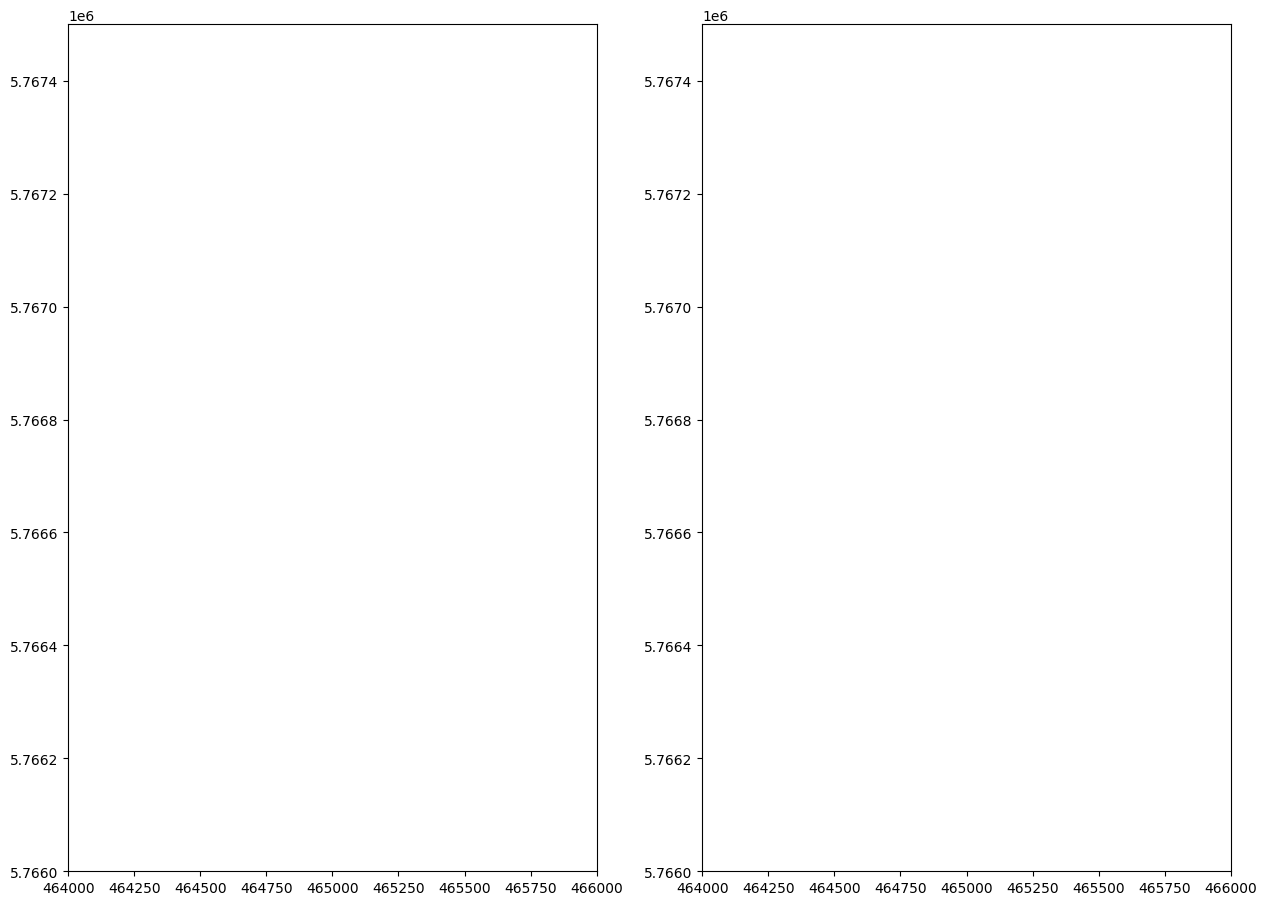

In [21]:
fig, (axfloat, axint) = plt.subplots(1,2, figsize=(15,11))
axfloat.set_xlim(464000, 466000)
axfloat.set_ylim(5766000, 5767500)
axint.set_xlim(464000, 466000)
axint.set_ylim(5766000, 5767500)
show(photo, ax=axfloat, title='dtype = float32')
show(photo_int8, ax=axint, title='dtype = uint7 (= signed int8) (0-128)')
plt.show()

I'm doing this a bit artificially now, but if we were to only use 6 bits for each colour, that would restrict us to 0-64. The degradation is a bit clearer now:

In [22]:
photo_uint6 = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color_uint6.tiff'
)

fig, (axfloat, axint) = plt.subplots(1,2, figsize=(15,11))
show(photo, ax=axfloat, title='dtype = float32')
show(photo_uint6, ax=axint, title='dtype = uint6 (0-64)')
plt.show()

RasterioIOError: HTTP response code: 404

Zooming in there's some more differences apparent:

NameError: name 'photo' is not defined

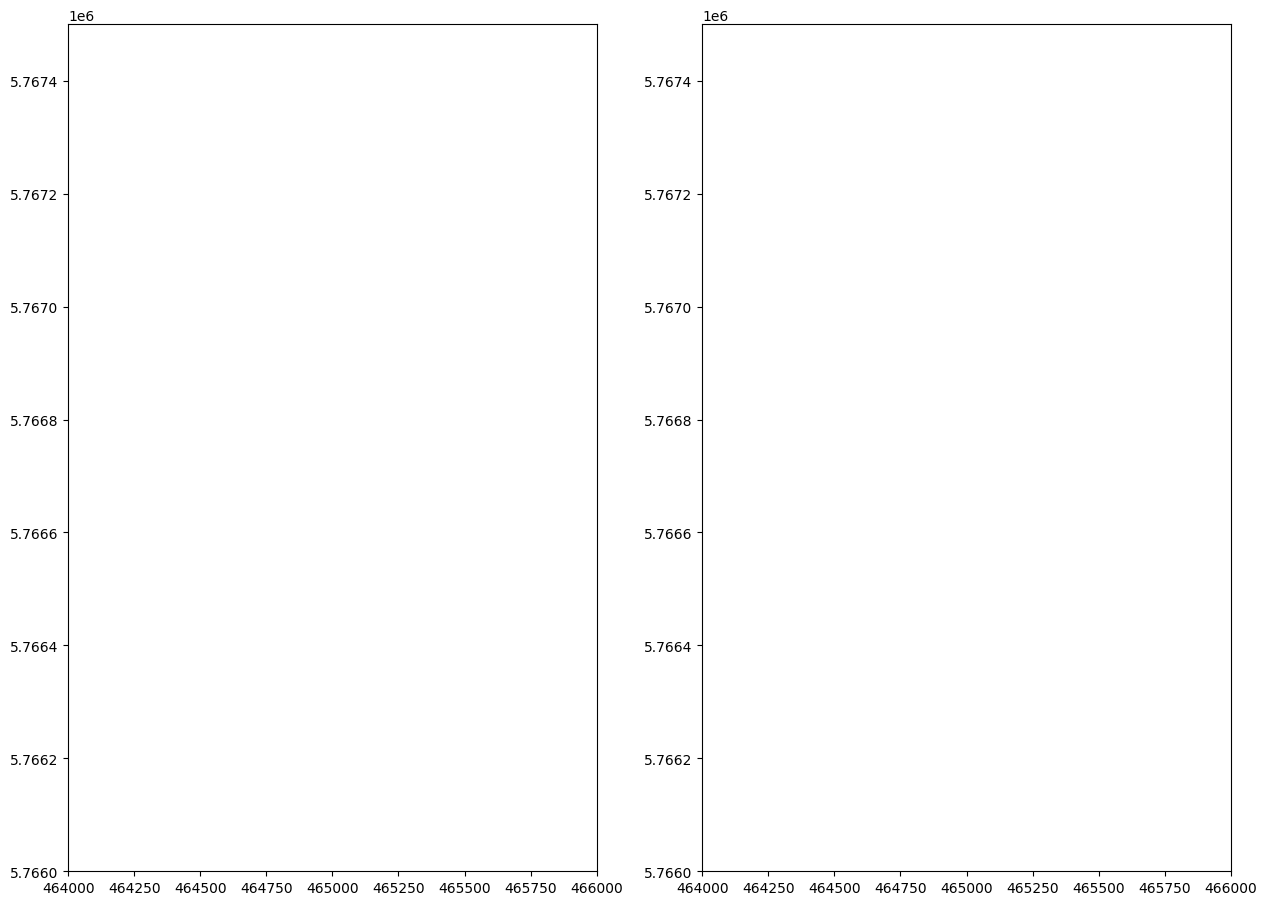

In [23]:
fig, (axfloat, axint) = plt.subplots(1,2, figsize=(15,11))
axfloat.set_xlim(464000, 466000)
axfloat.set_ylim(5766000, 5767500)
axint.set_xlim(464000, 466000)
axint.set_ylim(5766000, 5767500)
show(photo, ax=axfloat, title='dtype = float32')
show(photo_uint6, ax=axint, title='dtype = uint6 (0-64)')
plt.show()

If we were to use only 4 bits for each colour, the differences become very clear. Here, we have only 0-16 in each colour band:

In [24]:
photo_uint4 = rio.open(
    'https://raw.githubusercontent.com/bamacgabhann/GY4006/raw/main/gy4006/sample_data/Killarney/2021-04-25_11-46-59_Sentinel-2_L2A_True_color_uint4.tiff'
)

fig, (axfloat, axint) = plt.subplots(1,2, figsize=(15,11))
show(photo, ax=axfloat, title='dtype = float32')
show(photo_uint4, ax=axint, title='dtype = uint4 (0-16)')
plt.show()

RasterioIOError: HTTP response code: 404

Close up, this is starting to look *awful*:

NameError: name 'photo' is not defined

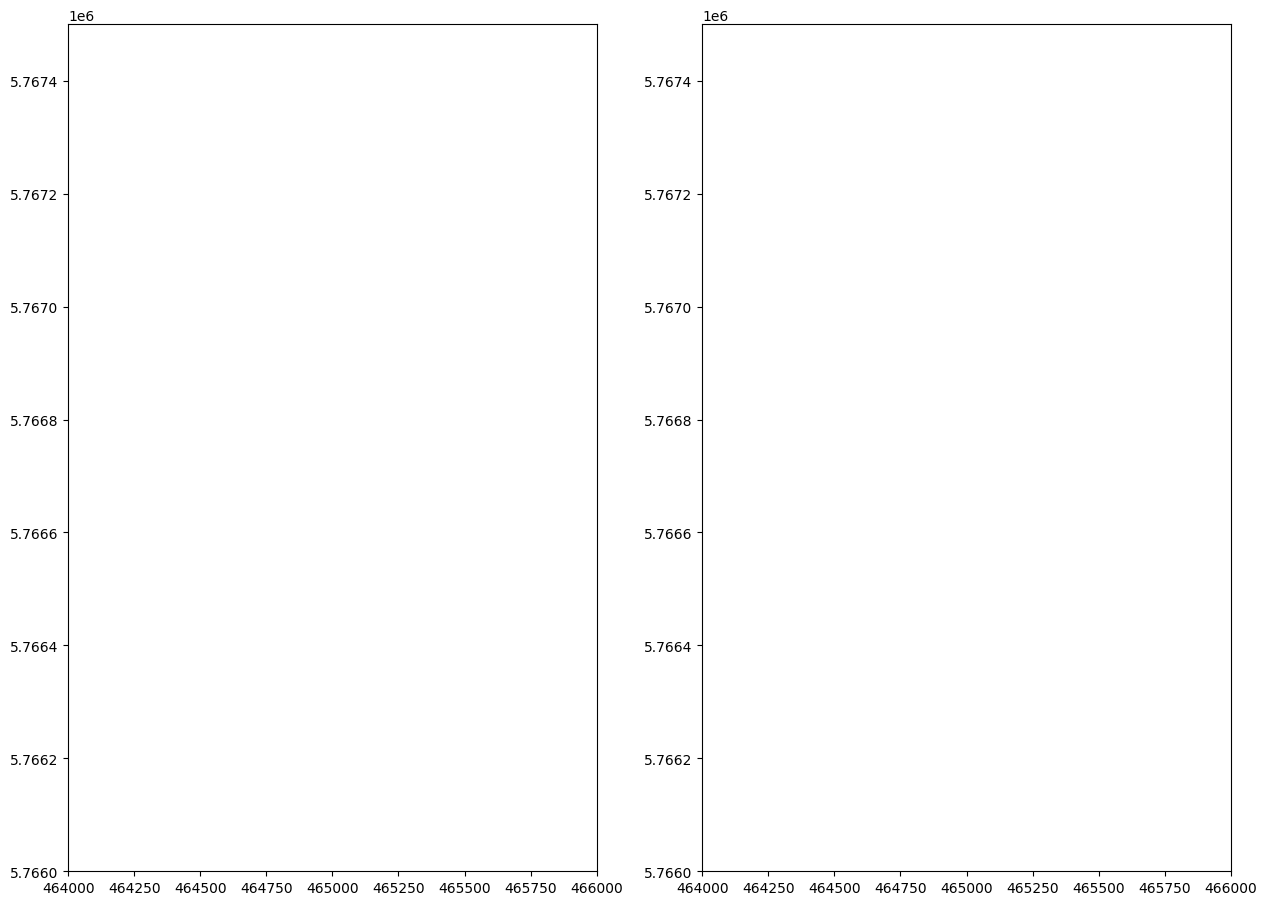

In [25]:
fig, (axfloat, axint) = plt.subplots(1,2, figsize=(15,11))
axfloat.set_xlim(464000, 466000)
axfloat.set_ylim(5766000, 5767500)
axint.set_xlim(464000, 466000)
axint.set_ylim(5766000, 5767500)
show(photo, ax=axfloat, title='dtype = float32')
show(photo_uint4, ax=axint, title='dtype = uint4 (0-64)')
plt.show()

The above is a bit artificial, you'd never get real images like this using 4-bits or 6-bits per colour, but the point I'm trying to make here is broader. Our eyes can distinguish the differences in the 4- and 6-bit images, and while above that we can't see much difference - computers can distinguish *far* more than our eyes. If you're trying to do complex analysis of imagery on a computer, then even the differences between 8-bit integers and 32-bit floats is enormous, and can make a very significant difference in the analysis.

So, this *spectral* resolution of the data is just as important as the spatial resolution. This is the precision of the dataset - or to put it another way, how much detail it's possible to store for each pixel.

Normally, the spectral resolution will be dictated by the sensor used to collect the data. How good your results will be depends on this - and it's really just a case of understanding the limits of what you have. There's no point trying to do fine-scale spectral analysis on data with a low spectral resolution, just as there's no point trying to map parking spaces, for example, on data with a spatial resolution of 10m - you just won't be able to see the differences.

## Summary

The key takeaways here are:

1. Image-type geospatial data is not used in vector format, but in raster format, where coordinates and a transform are specified for an entire array of pixels instead of giving the coordinates for each pixel separately.
2. Since pixels cover a discrete area, they have a spatial resolution - what distance they cover over the ground, which can be different in north-south and east-west directions.
3. The spectral resolution is the precision at which the data for each pixel is stored. This is just as important as spatial resolution.

It's not just actual images which can be presented in this raster format. Any data which varies discontinuously acruss an area can be stored as a raster, with other common examples including maps of temperature, rainfall, and, as we'll see in our next Notebook, the elevation of the land surface.

___

GY4006 Notebooks in Colab: 

2. Data Types <a href="https://colab.research.google.com/github/bamacgabhann/GY4006/blob/main/gy4006/notebooks/GY4006_2_Data_Types.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3. Vector Data <a href="https://colab.research.google.com/github/bamacgabhann/GY4006/blob/main/gy4006/notebooks/GY4006_3_Vector_Data.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4. Attribute Data <a href="https://colab.research.google.com/github/bamacgabhann/GY4006/blob/main/gy4006/notebooks/GY4006_4_Attribute_Data.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

5. Coordinate Reference Systems <a href="https://colab.research.google.com/github/bamacgabhann/GY4006/blob/main/gy4006/notebooks/GY4006_5_Coordinate_Reference_Systems.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

6. Geospatial Data Files <a href="https://colab.research.google.com/github/bamacgabhann/GY4006/blob/main/gy4006/notebooks/GY4006_6_Geospatial_Data_Files.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

7. Vector Geoprocessing <a href="https://colab.research.google.com/github/bamacgabhann/GY4006/blob/main/gy4006/notebooks/GY4006_7_Vector_Geoprocessing.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

8. Introduction to Raster Data <a href="https://colab.research.google.com/github/bamacgabhann/GY4006/blob/main/gy4006/notebooks/GY4006_8_Introduction_To_Raster_Data.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

9. Single-band Raster Data <a href="https://colab.research.google.com/github/bamacgabhann/GY4006/blob/main/gy4006/notebooks/GY4006_9_Single-band_Raster_Data.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

10. Multi-band Raster Data: Passive Remote Sensing <a href="https://colab.research.google.com/github/bamacgabhann/GY4006/blob/main/gy4006/notebooks/GY4006_10_Multi-band_Raster_Data-Passive_Remote_Sensing.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>